In this notebook, a section of a high-voltage cable is simulated (taken from the COMSOL project of EE4625 - High Voltage Cable Systems). The simulation is magnetostatics including a term for induced eddy currents. I hope that this will allow me to simulate the skin and proximity effect (the latter only for multiple cables!).

# Include Packages

In [1]:
using LinearAlgebra;
using Plots;

using gmsh;

using Gridap;
using GridapGmsh;

# Problem Definition
Section of cable.

Assumption: time-harmonic currents

## Geometry

In [66]:
ri = 19.1e-3;   # Cable inner radius
ro = 37.5e-3;   # Cable outer radius

lc1 = 2e-3;      # Mesh density at outside of cable
lc2 = 0.1e-3;   # Mesh density at the conductor edge

## Materials & Sources

In [156]:
I = 1000;            # Current in the cable [A]

mu0 = 4*pi*1e-7;     # Permeability of vacuum
omega = 2*pi*50;    # Frequency of the time-harmonic current

sigma_cond = 3.69e7;   # Conductivity of aluminium

# Define Geometry in gmsh

In [100]:
gmsh.finalize()
gmsh.initialize()

gmsh.option.setNumber("General.Terminal", 1)
gmsh.model.add("cable_skin")

# Points
gmsh.model.geo.addPoint(0, 0, 0, lc1, 1);
gmsh.model.geo.addPoint(ri, 0, 0, lc2, 2);
gmsh.model.geo.addPoint(ro, 0, 0, lc1, 3);
gmsh.model.geo.addPoint(0, ri, 0, lc2, 4);
gmsh.model.geo.addPoint(0, ro, 0, lc1, 5);

# Lines
gmsh.model.geo.addLine(1, 2, 1);
gmsh.model.geo.addLine(2, 3, 2);
gmsh.model.geo.addLine(1, 4, 3);
gmsh.model.geo.addLine(4, 5, 4);
gmsh.model.geo.addCircleArc(2, 1, 4, 5);
gmsh.model.geo.addCircleArc(3, 1, 5, 6);

# Surfaces
gmsh.model.geo.addCurveLoop([1, 5, -3], 1)
gmsh.model.geo.addCurveLoop([2, 6, -4, -5], 2)

gmsh.model.geo.addPlaneSurface([1], 1)
gmsh.model.geo.addPlaneSurface([2], 2)

# Physics
#  Dirichlet boundary on outside of cable
gmsh.model.addPhysicalGroup(0, [3, 5], 1)
gmsh.model.setPhysicalName(0, 1, "D1p")
gmsh.model.addPhysicalGroup(1, [6], 1)
gmsh.model.setPhysicalName(1, 1, "D1")

#  Neumann boundary on two insides
gmsh.model.addPhysicalGroup(0, [1, 2, 4], 2)
gmsh.model.setPhysicalName(0, 2, "N1p")
gmsh.model.addPhysicalGroup(1, [1, 2, 3, 4], 2)
gmsh.model.setPhysicalName(1, 2, "N1")

#  Material groups
gmsh.model.addPhysicalGroup(2, [1], 1)
gmsh.model.setPhysicalName(2, 1, "conductor")
gmsh.model.addPhysicalGroup(2, [2], 2)
gmsh.model.setPhysicalName(2, 2, "insulator")

# Generate mesh
gmsh.model.geo.synchronize()
gmsh.model.mesh.generate(2)

gmsh.write("cable_skin.msh")

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 20%] Meshing curve 2 (Line)
Info    : [ 40%] Meshing curve 3 (Line)
Info    : [ 50%] Meshing curve 4 (Line)
Info    : [ 70%] Meshing curve 5 (Circle)
Info    : [ 90%] Meshing curve 6 (Circle)
Info    : Done meshing 1D (Wall 0.0139639s, CPU 0.015625s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 50%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.31622s, CPU 0.3125s)
Info    : 7673 nodes 15650 elements
Info    : Writing 'cable_skin.msh'...
Info    : Done writing 'cable_skin.msh'


In [128]:
gmsh.fltk.run()

-------------------------------------------------------
Version       : 4.9.4
License       : GNU General Public License
Build OS      : Windows64-sdk
Build date    : 20220203
Build host    : gmsh.info
Build options : 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blas[petsc] Blossom Cgns DIntegration DomHex Eigen[contrib] Fltk Gmm[contrib] Hxt Jpeg Kbipack Lapack[petsc] MathEx[contrib] Med Mesh Metis[contrib] Mmg Mpeg Netgen NoSocklenT ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OpenMP OptHom PETSc Parser Plugins Png Post QuadMeshingTools QuadTri Solver TetGen/BR Voro++[contrib] WinslowUntangler Zlib
FLTK version  : 1.4.0
PETSc version : 3.15.0 (real arithmtic)
OCC version   : 7.6.0
MED version   : 4.1.0
Packaged by   : nt authority system
Web site      : https://gmsh.info
Issue tracker : https://gitlab.onelab.info/gmsh/gmsh/issues
-------------------------------------------------------


# Gridap

In [157]:
# Load geometry from gmsh
model = GmshDiscreteModel("cable_skin.msh")

# Create a reference Lagrangian finite element space to use for the construction of test space V0
order = 3
reffe = ReferenceFE(lagrangian, Float64, order);
# The test space is created from the reference FE with
#  conformity = H1: shape functions are continuous
#  D1 and D2 being the boundary points with Dirichlet condition applied
#  vector_type = ComplexF64 to allow for a complex input & output
V0 = TestFESpace(model, reffe; conformity = :H1, dirichlet_tags = ["D1", "D1p"], vector_type=Vector{ComplexF64});

# Trial space is constructed from the test space, giving the proper values for the Dirichlet boundary
Ug = TrialFESpace(V0, [0, 0]);

# Triangulation of the domain
#  degree must be at least 2 times the order of the reference space
degree = 2 * order;
Ω = Triangulation(model);
dΩ = Measure(Ω, degree);

# Define source functions
#  How to use Gridap to assign these to elements instead of positions?
J = I / (pi * ri*ri);
fsource(x) = -J * (sqrt(x[1]*x[1] + x[2]*x[2]) < ri);
cfun(x) = 1 / mu0;
sigmafun(x) = 1im * omega * sigma_cond * (sqrt(x[1]*x[1] + x[2]*x[2]) < ri);

# Construct weak form
lhs(u,v) = ∫( cfun * ∇(v) ⋅ ∇(u) + sigmafun * u ⋅ v )dΩ;
rhs(v)   = ∫( v * fsource  )dΩ;

# Construct FE operator with LHS, RHS, and test and trial spaces
op = AffineFEOperator(lhs, rhs, Ug, V0);

# Solve the linear FE system with LU solver
ls = LUSolver()
solver = LinearFESolver(ls)

uh = solve(solver, op);

Info    : Reading 'cable_skin.msh'...
Info    : 13 entities
Info    : 7673 nodes
Info    : 15349 elements
Info    : Done reading 'cable_skin.msh'


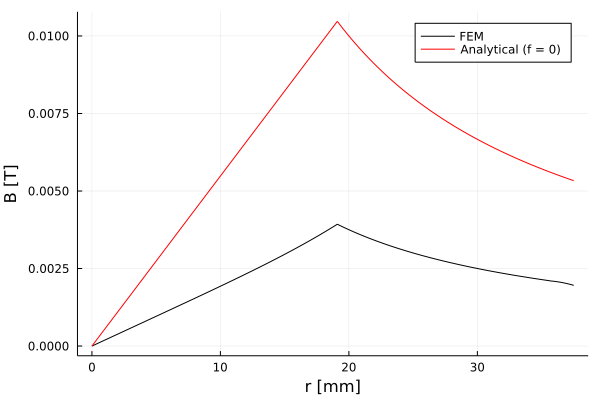

In [158]:
B = ∇(uh);
J = laplacian(uh) / mu0;

x = Vector(0:ro/1000:ro)
coord = [Point(x[i], 0) for i in 1:length(x)];
u_line = uh(coord);
B_line = B(coord);
J_line = J(coord);

B_line = [(sqrt(norm(B[1])^2 + norm(B[2])^2))  for B in B_line];

p1 = plot(x * 1e3, B_line, color = :black, xlabel = "r [mm]", ylabel = "B [T]", label = "FEM")
p1 = plot!(x * 1e3, mu0 * I ./ (2*pi*ri^2) .* x .* (x .< ri) + mu0 * I ./ (2 * pi * x) .* (x .>= ri), color = :red, label = "Analytical (f = 0)")

Because the total current flowing through the cable must stay $I$, the magnetic field at the edge of the conductor must always have the same value, no matter the frequency.
$$ B(r_i) = \frac{\mu_0 I}{2\pi r_i} $$
The same goes for the magnetic field outside the conductor. Because of the eddy currents, the distribution inside the conductor may change with frequency.

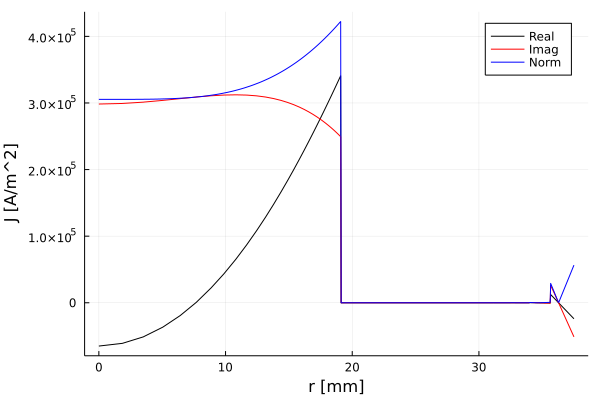

In [159]:
p2 = plot(x * 1e3, real(J_line), color = :black, xlabel = "r [mm]", ylabel = "J [A/m^2]", label = "Real")
p2 = plot!(x * 1e3, imag(J_line), color = :red, xlabel = "r [mm]", ylabel = "J [A/m^2]", label = "Imag")
p2 = plot!(x * 1e3, norm.(J_line), color = :blue, xlabel = "r [mm]", ylabel = "J [A/m^2]", label = "Norm")

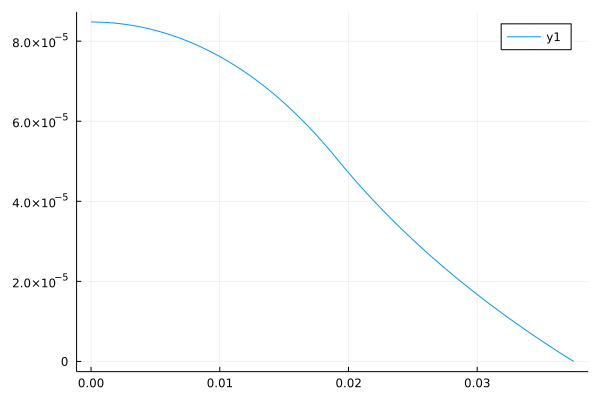

In [160]:
plot(x, norm.(u_line))

# Write to VTK

In [161]:
writevtk(Ω,"cable_skin",cellfields=["A"=>abs(uh), "J"=>abs(J)])

(["cable_skin.vtu"],)